In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import models, optimizers, losses, metrics, layers, applications

In [2]:
original_content = plt.imread("dog.jpg")
original_style = plt.imread("pictures.jpg")

content = cv2.resize(original_content, dsize=(224, 224))
style = cv2.resize(original_style, dsize=(224, 224))

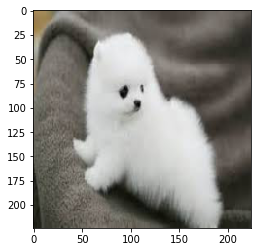

In [3]:
plt.imshow(content)

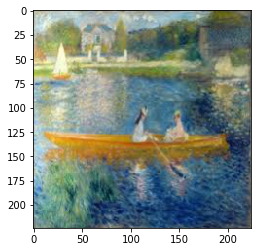

In [4]:
plt.imshow(style)

In [5]:
content = content.astype(np.float32) / 256
style = style.astype(np.float32) / 256

In [6]:
vgg = applications.VGG16()

In [7]:
vgg.layers[:18]

In [8]:
class StyleTransfer(models.Model):
    
    def __init__(self, *args, **kwargs):
        super(StyleTransfer, self).__init__(*args, **kwargs)
        
        self.vgg = applications.VGG16()
        self.vgg.trainable = False
        
        self.layer_indices = [2, 5, 9, 13, 17]
        
    @tf.function
    def call(self, x, content, style, training=False):
        x1 = x
        x2 = content
        x3 = style
        
        content_loss = 0.0
        style_loss = 0.0
        
        for i, layer in enumerate(self.vgg.layers[:18]):
            x1 = layer(x1, training=training)
            x2 = layer(x2, training=training)
            x3 = layer(x3, training=training)
            
            if i in self.layer_indices:
                content_loss += self._content_loss(x1, x2)
                style_loss += self._style_loss(x1, x3)
                
        return content_loss, style_loss
        
    def _content_loss(self, target_output, content_output):
        return tf.reduce_mean((target_output - content_output)**2)
        
    def _style_loss(self, target_output, style_output):
        target_gram = self._gram_matrix(tf.squeeze(target_output))
        style_gram = self._gram_matrix(tf.squeeze(style_output))
        
        style_loss = tf.reduce_mean((target_gram - style_gram)**2)
            
        return style_loss
        
    def _gram_matrix(self, features):
        c = tf.shape(features)[2]
        
        features = tf.transpose(features, [2, 0, 1])
        features = tf.reshape(features, (c, -1))
            
        return tf.matmul(features, tf.transpose(features, (1, 0)))

In [14]:

def train_step(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        content_loss, style_loss = model(x, content, style)
        
        loss = 10*content_loss + 0.5*style_loss
        
    grads = tape.gradient(loss, x)
    optimizer.apply_gradients([(grads, x)])
    
    return loss

In [10]:
model = StyleTransfer()
x = tf.Variable(tf.zeros((1, 224, 224, 3)))

optimizer = optimizers.Adam(1e-2)

Loss: 730597.375


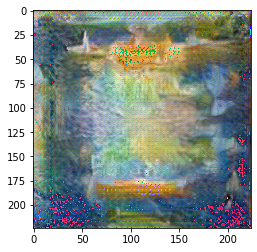

Loss: 6290410.0


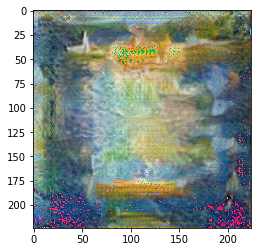

Loss: 711383.125


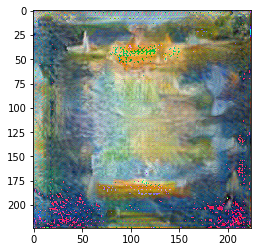

Loss: 700221.625


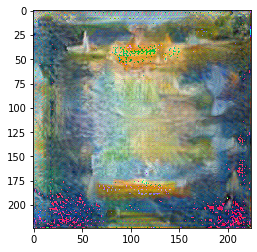

Loss: 830778.125


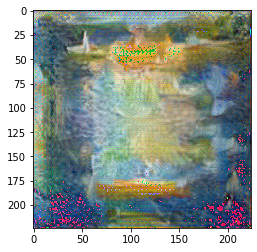

Loss: 696352.5625


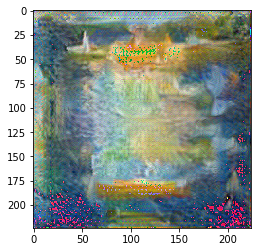

Loss: 1277079.125


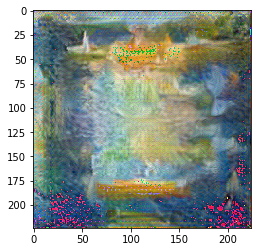

Loss: 584883.1875


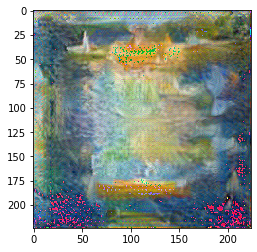

Loss: 1319719.375


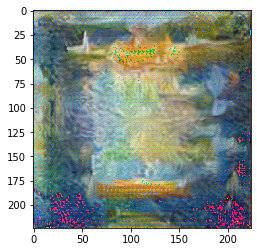

Loss: 703245.3125


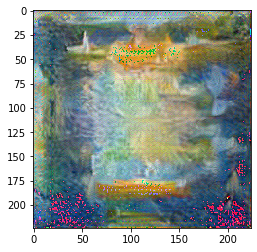

Loss: 616266.625


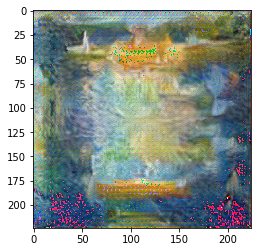

Loss: 576832.75


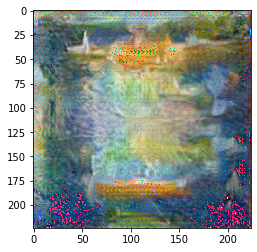

Loss: 1220756.875


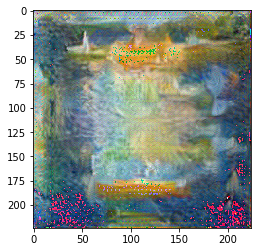

Loss: 811150.0


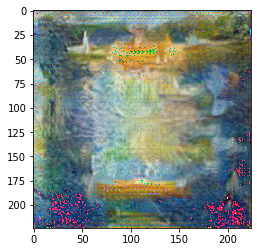

Loss: 565164.5625


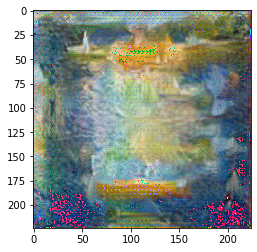

Loss: 1964921.75


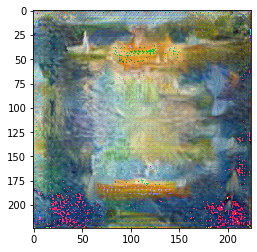

Loss: 634639.5625


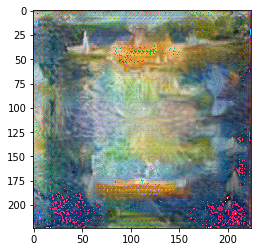

Loss: 12597957.0


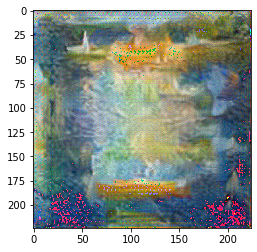

Loss: 701359.9375


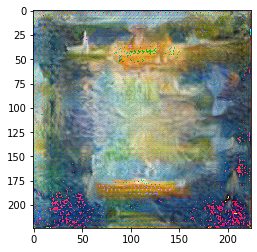

Loss: 575553.5


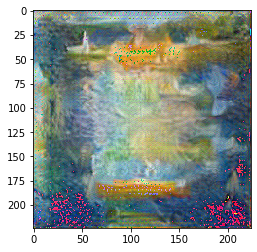

Loss: 531153.0


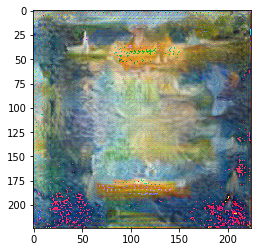

Loss: 496644.46875


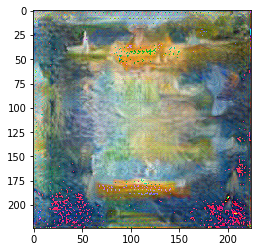

Loss: 481373.71875


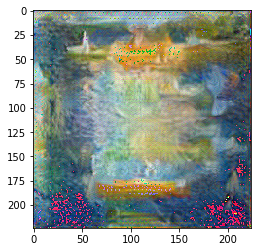

Loss: 1305954.5


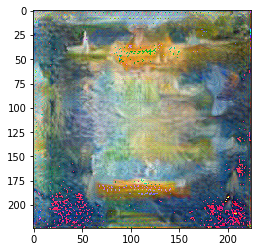

Loss: 471278.96875


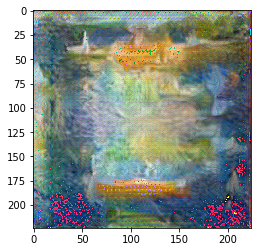

Loss: 450716.78125


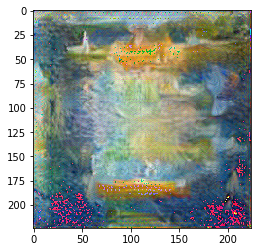

Loss: 505951.46875


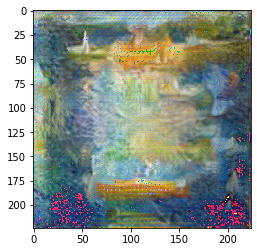

Loss: 2490499.75


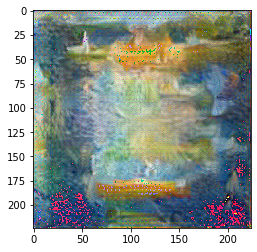

Loss: 1046768.4375


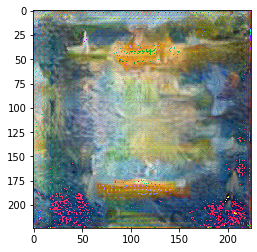

Loss: 497258.34375


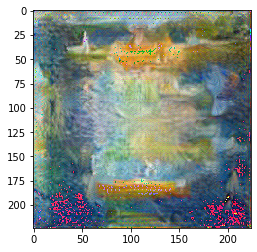

Loss: 498529.28125


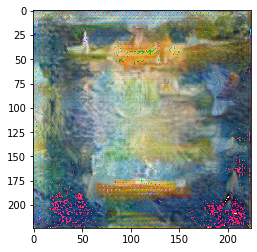

In [15]:
content = tf.reshape(content, (1, 224, 224, 3))
style = tf.reshape(style, (1, 224, 224, 3))

for e in range(3000):
    loss = train_step(x)
                              
    if (e+1)%100 == 0 or e == 0:
        x_numpy = x.numpy().squeeze()
        x_numpy *= 256
        x_numpy = x_numpy.astype(np.uint8)
        
        print(f"Loss: {loss.numpy()}")
        plt.imshow(x_numpy)
        plt.show()